# Testing patching functions in acdc.py
## Setup

In [1]:
# Imports
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm
import sys
sys.path.append('..')

from einops import rearrange
import torch as t
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE
from acdc import patching_on_y, patching_on_downstream_feature

import matplotlib.pyplot as plt
import pandas as pd
import imageio
from circuitsvis.activations import text_neuron_activations

/home/can/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global variables
ACTIVATION_DIM = 512
DICTIONARY_SIZE = 64 * ACTIVATION_DIM # This is the dict_size sam mostly works with.
EPS = 1e-8

In [3]:
# Model and SAEs
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodules = [
    layer.mlp for layer in model.gpt_neox.layers
]

dictionaries = []
for i in range(len(submodules)):
    dictionary = AutoEncoder(ACTIVATION_DIM, DICTIONARY_SIZE).to('cuda:0')
    dictionary.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/1_32768/ae.pt'))
    dictionaries.append(dictionary)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# Toy dataset for the "Plural" task

plural_token_pos = 1
tok = lambda x: t.tensor(model.tokenizer.encode(x))
toy_dataset = [dict(
    clean_prefix=tok("The man"),
    clean_answer=tok(" is"),
    patch_prefix=tok("The men"),
    patch_answer=tok(" are"),

)]

toy_dataset[0]['clean_prefix']

tensor([510, 637])

In [5]:
# Diverse dataset for Circuitvis evaluation

# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

# Buffer tied to one specific submodule!
buffer = ActivationBuffer(
    data,
    model,
    submodules[0], # we only use data from the buffer, not acttivations. Thus we can pass any submodule here
    io='out',
    in_feats=ACTIVATION_DIM,
    out_feats=ACTIVATION_DIM,
    in_batch_size=512,
    out_batch_size=2 ** 15,
    n_ctxs=1e4,
)

tokenized_prompts = buffer.tokenized_batch(batch_size=512) # [batch, n_ctx]

In [6]:
# Circuitsvis visualization

def get_feature_activations(layer):
    '''
    Function for retrieving feature activations from tokenized batch
    returns activations for all submodules, dictionaries if layer == None
    
    '''
    with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
        with generator.invoke(tokenized_prompts['input_ids'], scan=False) as invoker:
            hidden_states = submodules[layer].output.save() # hidden_states.value: [batch, n_ctx, d_mlp]
    dictionary_activation = dictionaries[layer].encode(hidden_states.value)
    return dictionary_activation

def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]
    
def topk_prompts_provider(feature_layer: int, feature_id: int, k: int = 30):
    # Sort examples in batch by max feature activation
    dictionary_activations = get_feature_activations(feature_layer)
    acts = dictionary_activations[:, :, feature_id].cpu() # acts: [batch, pos]
    flattened_acts = rearrange(acts, 'b l -> (b l)')
    topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k] 
    batch_indices = topk_indices // acts.shape[1]
    token_indices = topk_indices % acts.shape[1]

    # Visualize
    tokens = [
    tokenized_prompts['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
    ]
    tokens = list_decode(tokens)
    activations = [
        acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
    ]
    return tokens, activations

## Testing `patching_on_y`
Evaluate causal effects of features in layer 5 on the logit diff between clean and patch answers.

In [7]:
layer_patching_on_y = 5

In [8]:
effects_on_y, total_effect_on_y = patching_on_y(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    method='all-folded'
)

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect_on_y}')

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


total metric diff after replacing clean prefix with patch prefix: 8.8028564453125


In [9]:
# Top 10 features in layer `layer_patching_on_y` with highest impact on logit diff

# Only effect on token position `plural_token_pos` matters for "Plurals" task
effects_on_y = effects_on_y[submodules[layer_patching_on_y]][plural_token_pos].detach().cpu()
top_effects_on_y = t.argsort(effects_on_y, descending=True)[:10]
top_features_on_y = []
print(f'Top 10 features in layer {layer_patching_on_y} with highest impact on logit diff')
for i in top_effects_on_y:
    top_features_on_y.append(i)
    print(f'feat {i}:\t {effects_on_y[i]}')

Top 10 features in layer 5 with highest impact on logit diff
feat 22167:	 0.15118589997291565
feat 7352:	 0.0881505087018013
feat 10880:	 0.07269265502691269
feat 14747:	 0.06640410423278809
feat 13505:	 0.05375915765762329
feat 19033:	 0.023533198982477188
feat 20780:	 0.02276180312037468
feat 30204:	 0.013442937284708023
feat 5580:	 0.012757625430822372
feat 25775:	 0.011507009156048298


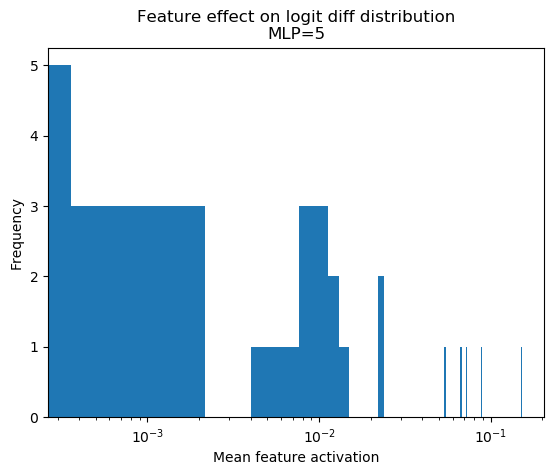

In [10]:
plt.figure()
plt.hist(effects_on_y[effects_on_y.abs() > EPS], bins=100)
plt.xscale('log')
plt.title(f'Feature effect on logit diff distribution\nMLP={layer_patching_on_y}');
plt.xlabel('Mean feature activation')
plt.ylabel('Frequency');

In [11]:
# Need to stack functions to display circuitvis properly
text_neuron_activations(
    *topk_prompts_provider(
        feature_layer=layer_patching_on_y, 
        feature_id=top_features_on_y[0],
        k=5
))

5/22167 seems to activate on singular nouns related do people.

## Testing `patching_on_downstream_feature`

In [12]:
downstream_feat_layer = 5
downstream_feat_id = 22167

k_upstream_feats = 3

In [20]:
effects_on_dsfeat, total_effect_on_dsfeat = patching_on_downstream_feature(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    downstream_feature_layer=downstream_feat_layer,
    downstream_feature_id=downstream_feat_id, 
    method='all-folded'
)

print(f'total metric diff after replacing clean prefix with patch prefix: {total_effect_on_dsfeat}')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
# Top k features per layer with highest impact on downstream feat activation

topk_upstream_feats = t.zeros((len(submodules), k_upstream_feats), dtype=int)
print(f'Top {k_upstream_feats} features per layer with highest impact on downstream feat activation')

for layer in range(len(submodules)):
    print(f'\nLayer {layer}:')
    effects_on_dsfeat_per_layer = effects_on_dsfeat[submodules[layer]][plural_token_pos].detach().cpu() # Only effect on token position `plural_token_pos` matters for "Plurals" task
    topk_upstream_feats[layer] = t.argsort(effects_on_dsfeat_per_layer, descending=True)[:k_upstream_feats]
    for i in topk_upstream_feats[layer]:
        print(f'feat {i}:\t {effects_on_dsfeat_per_layer[i]}')

Top 3 features per layer with highest impact on downstream feat activation

Layer 0:
feat 21840:	 0.0
feat 21855:	 0.0
feat 21854:	 0.0

Layer 1:
feat 14400:	 0.06060613691806793
feat 1566:	 0.014259410090744495
feat 10964:	 0.013167855329811573

Layer 2:
feat 12654:	 0.02732522413134575
feat 27186:	 0.02288554236292839
feat 31615:	 0.014543569646775723

Layer 3:
feat 26928:	 0.09637608379125595
feat 20945:	 0.028065158054232597
feat 30457:	 0.015654182061553

Layer 4:
feat 2871:	 0.07770593464374542
feat 28130:	 0.00389579264447093
feat 11028:	 0.0014464699197560549

Layer 5:
feat 7352:	 0.056569550186395645
feat 5580:	 0.05062364414334297
feat 20780:	 0.03504457697272301


Top 1 features per layer found seem to be related to the plurals task!

Values in same or later layer are generally uninterpretable.
I expect that, xact patching should yield 0 unconnected features in same or later layer. (No bwdpass involved)

In [15]:
tokens, activations = topk_prompts_provider(
    feature_layer=3,
    feature_id=26928,
    k=5
)
text_neuron_activations(tokens, activations)

### Check wheter different patching methods agree in which upstream features have the highest effect on the downstream feature

In [16]:
methods = ['all-folded', 'separate', 'ig'] #, 'exact']
topk_upstream_feats_across_methods = pd.DataFrame()
df_idx = []
for method in methods:
    topk_upstream_feats = t.zeros((len(submodules), k_upstream_feats), dtype=int)

    effects_on_dsfeat, total_effect_on_dsfeat = patching_on_downstream_feature(
        toy_dataset,
        model,
        submodules,
        dictionaries,
        downstream_feature_layer=downstream_feat_layer,
        downstream_feature_id=downstream_feat_id, 
        method=method,
    )
    for layer in range(len(submodules)):
        effects_on_dsfeat_per_layer = effects_on_dsfeat[submodules[layer]][plural_token_pos].detach().cpu() # Only effect on token position `plural_token_pos` matters for "Plurals" task
        topk_upstream_feats[layer] = t.argsort(effects_on_dsfeat_per_layer, descending=True)[:k_upstream_feats]
        if len(df_idx) < len(submodules) * k_upstream_feats:
            df_idx += [f'layer{layer}_top{i+1}' for i in range(k_upstream_feats)]

    topk_upstream_feats_across_methods[method] = topk_upstream_feats.flatten()

topk_upstream_feats_across_methods.index = df_idx
topk_upstream_feats_across_methods

,all-folded,separate,ig
layer0_top1,21840,15149,21840
layer0_top2,21855,21848,21855
layer0_top3,21854,21841,21854
layer1_top1,14400,14400,14400
layer1_top2,1566,25045,25045
layer1_top3,10964,10964,10964
layer2_top1,12654,12654,12654
layer2_top2,27186,27186,27186
layer2_top3,31615,13579,13579
layer3_top1,26928,26928,26928


## Iterative circuit discovery
TopK features from each layer with highes effect on metric
For each feature found: Top k features with highest absolute effect

In [17]:
from collections import namedtuple
FeatureEffect = namedtuple('FeatureEffect', ['upstream_feature_layer', 'upstream_feature_id', 'downstream_feature_layer', 'downstream_feature_id', 'effect'])
MetricEffect = namedtuple('MetricEffect', ['upstream_feature_layer', 'upstream_feature_id', 'effect'])

In [ ]:
k = 3

effect_list = []
feature_queue = []

# Run patching on y once
effects_on_y, _ = patching_on_y(
    toy_dataset,
    model,
    submodules,
    dictionaries,
    method='all-folded'
)

for layer, submodule in enumerate(submodules):
    topk_features = t.argsort(effects_on_y[submodule], descending=True)[:k]
    for feat_id in topk_features:
        eff = MetricEffect(
            upstream_feature_layer=layer,
            upstream_feature_id=feat_id,
            effect=effects_on_y[submodule][feat_id]
        )
        effect_list.append(eff)
        feature_queue.append(eff)

In [ ]:
# Run patching on all features in queue
while len(feature_queue) > 0:
    feature_layer, feature_id, _, _, _ = feature_queue.pop(0)
    
    effects_on_dsfeat, total_effect_on_dsfeat = patching_on_downstream_feature( # TODO adapt this method to only calculate values for features in layers above downstream feature? Possible for attribution patching methods gradent requires full bwd pass?
        toy_dataset,
        model,
        submodules,
        dictionaries,
        downstream_feature_layer=feature_layer,
        downstream_feature_id=feature_id, 
        method='all-folded'
    )

    for layer, submodule in enumerate(submodules[:feature_layer]): # Only layers above downstream feature considered.
        topk_features = t.argsort(effects_on_y[submodule], descending=True)[:k]
        for feat_id in topk_features:
            eff = MetricEffect(
                upstream_feature_layer=layer,
                upstream_feature_id=feat_id,
                effect=effects_on_y[submodule][feat_id]
            )
            effect_list.append(eff)
            feature_queue.append(eff)
    

## Evaluating the context for features in effect list.
- Automatically using LLM?